# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 7.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 24.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 43.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 300 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secret']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secret']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp20 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 23 00:59:39 +0000 2020'
'Mon Nov 23 00:59:37 +0000 2020'
'Mon Nov 23 00:58:58 +0000 2020'
'Mon Nov 23 00:58:57 +0000 2020'
'Mon Nov 23 00:58:40 +0000 2020'
'Mon Nov 23 00:58:05 +0000 2020'
'Mon Nov 23 00:57:56 +0000 2020'
'Mon Nov 23 00:57:52 +0000 2020'
'Mon Nov 23 00:57:38 +0000 2020'
'Mon Nov 23 00:57:19 +0000 2020'
'Mon Nov 23 00:57:13 +0000 2020'
'Mon Nov 23 00:57:05 +0000 2020'
'Mon Nov 23 00:56:22 +0000 2020'
'Mon Nov 23 00:55:54 +0000 2020'
'Mon Nov 23 00:55:48 +0000 2020'
'Mon Nov 23 00:55:15 +0000 2020'
'Mon Nov 23 00:54:26 +0000 2020'
'Mon Nov 23 00:54:21 +0000 2020'
'Mon Nov 23 00:54:09 +0000 2020'
'Mon Nov 23 00:54:02 +0000 2020'
'Mon Nov 23 00:53:38 +0000 2020'
'Mon Nov 23 00:53:21 +0000 2020'
'Mon Nov 23 00:52:46 +0000 2020'
'Mon Nov 23 00:52:32 +0000 2020'
'Mon Nov 23 00:52:31 +0000 2020'
'Mon Nov 23 00:51:20 +0000 2020'
'Mon Nov 23 00:51:08 +0000 2020'
'Mon Nov 23 00:51:03 +0000 2020'
'Mon Nov 23 00:51:01 +0000 2020'
'Mon Nov 23 00:50:50 +0000 2020'
'Mon Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 23 00:29:43 +0000 2020'
'Mon Nov 23 00:29:40 +0000 2020'
'Mon Nov 23 00:29:25 +0000 2020'
'Mon Nov 23 00:28:59 +0000 2020'
'Mon Nov 23 00:28:55 +0000 2020'
'Mon Nov 23 00:28:46 +0000 2020'
'Mon Nov 23 00:28:45 +0000 2020'
'Mon Nov 23 00:28:41 +0000 2020'
'Mon Nov 23 00:28:26 +0000 2020'
'Mon Nov 23 00:28:07 +0000 2020'
'Mon Nov 23 00:27:58 +0000 2020'
'Mon Nov 23 00:27:41 +0000 2020'
'Mon Nov 23 00:27:27 +0000 2020'
'Mon Nov 23 00:27:25 +0000 2020'
'Mon Nov 23 00:27:17 +0000 2020'
'Mon Nov 23 00:27:10 +0000 2020'
'Mon Nov 23 00:27:09 +0000 2020'
'Mon Nov 23 00:27:00 +0000 2020'
'Mon Nov 23 00:26:22 +0000 2020'
'Mon Nov 23 00:26:05 +0000 2020'
'Mon Nov 23 00:25:50 +0000 2020'
'Mon Nov 23 00:25:44 +0000 2020'
'Mon Nov 23 00:24:15 +0000 2020'
'Mon Nov 23 00:24:11 +0000 2020'
'Mon Nov 23 00:24:06 +0000 2020'
'Mon Nov 23 00:24:04 +0000 2020'
'Mon Nov 23 00:23:44 +0000 2020'
'Mon Nov 23 00:23:24 +0000 2020'
'Mon Nov 23 00:22:33 +0000 2020'
'Mon Nov 23 00:22:22 +0000 2020'
'Mon Nov 2

'Sun Nov 22 23:13:16 +0000 2020'
'Sun Nov 22 23:13:06 +0000 2020'
'Sun Nov 22 23:12:56 +0000 2020'
'Sun Nov 22 23:12:52 +0000 2020'
'Sun Nov 22 23:12:43 +0000 2020'
'Sun Nov 22 23:12:18 +0000 2020'
'Sun Nov 22 23:12:17 +0000 2020'
'Sun Nov 22 23:12:16 +0000 2020'
'Sun Nov 22 23:12:12 +0000 2020'
'Sun Nov 22 23:12:05 +0000 2020'
'Sun Nov 22 23:12:00 +0000 2020'
'Sun Nov 22 23:11:22 +0000 2020'
'Sun Nov 22 23:10:54 +0000 2020'
'Sun Nov 22 23:10:50 +0000 2020'
'Sun Nov 22 23:10:20 +0000 2020'
'Sun Nov 22 23:09:59 +0000 2020'
'Sun Nov 22 23:09:55 +0000 2020'
'Sun Nov 22 23:09:11 +0000 2020'
'Sun Nov 22 23:08:21 +0000 2020'
'Sun Nov 22 23:07:27 +0000 2020'
'Sun Nov 22 23:06:52 +0000 2020'
'Sun Nov 22 23:06:50 +0000 2020'
'Sun Nov 22 23:06:47 +0000 2020'
'Sun Nov 22 23:06:30 +0000 2020'
'Sun Nov 22 23:06:05 +0000 2020'
'Sun Nov 22 23:06:03 +0000 2020'
'Sun Nov 22 23:05:52 +0000 2020'
'Sun Nov 22 23:05:17 +0000 2020'
'Sun Nov 22 23:05:14 +0000 2020'
'Sun Nov 22 23:05:08 +0000 2020'
'Sun Nov 2

'Sun Nov 22 22:29:50 +0000 2020'
'Sun Nov 22 22:29:36 +0000 2020'
'Sun Nov 22 22:29:34 +0000 2020'
'Sun Nov 22 22:29:21 +0000 2020'
'Sun Nov 22 22:29:07 +0000 2020'
'Sun Nov 22 22:29:00 +0000 2020'
'Sun Nov 22 22:29:00 +0000 2020'
'Sun Nov 22 22:29:00 +0000 2020'
'Sun Nov 22 22:28:43 +0000 2020'
'Sun Nov 22 22:28:29 +0000 2020'
'Sun Nov 22 22:28:11 +0000 2020'
'Sun Nov 22 22:28:00 +0000 2020'
'Sun Nov 22 22:28:00 +0000 2020'
'Sun Nov 22 22:27:55 +0000 2020'
'Sun Nov 22 22:27:53 +0000 2020'
'Sun Nov 22 22:27:51 +0000 2020'
'Sun Nov 22 22:27:49 +0000 2020'
'Sun Nov 22 22:27:34 +0000 2020'
'Sun Nov 22 22:27:12 +0000 2020'
'Sun Nov 22 22:27:01 +0000 2020'
'Sun Nov 22 22:26:52 +0000 2020'
'Sun Nov 22 22:26:29 +0000 2020'
'Sun Nov 22 22:26:24 +0000 2020'
'Sun Nov 22 22:26:24 +0000 2020'
'Sun Nov 22 22:26:23 +0000 2020'
'Sun Nov 22 22:26:13 +0000 2020'
'Sun Nov 22 22:26:03 +0000 2020'
'Sun Nov 22 22:26:02 +0000 2020'
'Sun Nov 22 22:25:55 +0000 2020'
'Sun Nov 22 22:25:44 +0000 2020'
'Sun Nov 2

'Sun Nov 22 21:43:34 +0000 2020'
'Sun Nov 22 21:43:29 +0000 2020'
'Sun Nov 22 21:42:34 +0000 2020'
'Sun Nov 22 21:42:19 +0000 2020'
'Sun Nov 22 21:42:05 +0000 2020'
'Sun Nov 22 21:42:02 +0000 2020'
'Sun Nov 22 21:41:44 +0000 2020'
'Sun Nov 22 21:41:34 +0000 2020'
'Sun Nov 22 21:41:15 +0000 2020'
'Sun Nov 22 21:41:05 +0000 2020'
'Sun Nov 22 21:40:48 +0000 2020'
'Sun Nov 22 21:40:46 +0000 2020'
'Sun Nov 22 21:40:43 +0000 2020'
'Sun Nov 22 21:40:42 +0000 2020'
'Sun Nov 22 21:40:29 +0000 2020'
'Sun Nov 22 21:40:24 +0000 2020'
'Sun Nov 22 21:40:12 +0000 2020'
'Sun Nov 22 21:40:09 +0000 2020'
'Sun Nov 22 21:40:05 +0000 2020'
'Sun Nov 22 21:39:38 +0000 2020'
'Sun Nov 22 21:39:23 +0000 2020'
'Sun Nov 22 21:39:12 +0000 2020'
'Sun Nov 22 21:39:07 +0000 2020'
'Sun Nov 22 21:39:02 +0000 2020'
'Sun Nov 22 21:38:05 +0000 2020'
'Sun Nov 22 21:37:35 +0000 2020'
'Sun Nov 22 21:37:16 +0000 2020'
'Sun Nov 22 21:37:08 +0000 2020'
'Sun Nov 22 21:36:55 +0000 2020'
'Sun Nov 22 21:36:41 +0000 2020'
'Sun Nov 2

'Sun Nov 22 20:58:13 +0000 2020'
'Sun Nov 22 20:58:08 +0000 2020'
'Sun Nov 22 20:58:08 +0000 2020'
'Sun Nov 22 20:58:07 +0000 2020'
'Sun Nov 22 20:58:04 +0000 2020'
'Sun Nov 22 20:58:00 +0000 2020'
'Sun Nov 22 20:57:50 +0000 2020'
'Sun Nov 22 20:57:42 +0000 2020'
'Sun Nov 22 20:57:38 +0000 2020'
'Sun Nov 22 20:57:37 +0000 2020'
'Sun Nov 22 20:56:56 +0000 2020'
'Sun Nov 22 20:56:32 +0000 2020'
'Sun Nov 22 20:56:09 +0000 2020'
'Sun Nov 22 20:55:46 +0000 2020'
'Sun Nov 22 20:55:41 +0000 2020'
'Sun Nov 22 20:55:31 +0000 2020'
'Sun Nov 22 20:55:28 +0000 2020'
'Sun Nov 22 20:55:10 +0000 2020'
'Sun Nov 22 20:55:09 +0000 2020'
'Sun Nov 22 20:55:03 +0000 2020'
'Sun Nov 22 20:54:43 +0000 2020'
'Sun Nov 22 20:54:43 +0000 2020'
'Sun Nov 22 20:54:43 +0000 2020'
'Sun Nov 22 20:54:42 +0000 2020'
'Sun Nov 22 20:54:42 +0000 2020'
'Sun Nov 22 20:54:42 +0000 2020'
'Sun Nov 22 20:54:41 +0000 2020'
'Sun Nov 22 20:54:41 +0000 2020'
'Sun Nov 22 20:54:30 +0000 2020'
'Sun Nov 22 20:54:13 +0000 2020'
'Sun Nov 2

'Sun Nov 22 19:57:25 +0000 2020'
'Sun Nov 22 19:57:24 +0000 2020'
'Sun Nov 22 19:56:13 +0000 2020'
'Sun Nov 22 19:56:09 +0000 2020'
'Sun Nov 22 19:55:55 +0000 2020'
'Sun Nov 22 19:55:06 +0000 2020'
'Sun Nov 22 19:55:01 +0000 2020'
'Sun Nov 22 19:54:56 +0000 2020'
'Sun Nov 22 19:54:32 +0000 2020'
'Sun Nov 22 19:54:16 +0000 2020'
'Sun Nov 22 19:54:09 +0000 2020'
'Sun Nov 22 19:53:54 +0000 2020'
'Sun Nov 22 19:53:54 +0000 2020'
'Sun Nov 22 19:53:47 +0000 2020'
'Sun Nov 22 19:53:10 +0000 2020'
'Sun Nov 22 19:53:07 +0000 2020'
'Sun Nov 22 19:52:37 +0000 2020'
'Sun Nov 22 19:52:36 +0000 2020'
'Sun Nov 22 19:52:25 +0000 2020'
'Sun Nov 22 19:52:19 +0000 2020'
'Sun Nov 22 19:52:14 +0000 2020'
'Sun Nov 22 19:52:09 +0000 2020'
'Sun Nov 22 19:52:08 +0000 2020'
'Sun Nov 22 19:52:00 +0000 2020'
'Sun Nov 22 19:51:53 +0000 2020'
'Sun Nov 22 19:51:34 +0000 2020'
'Sun Nov 22 19:51:32 +0000 2020'
'Sun Nov 22 19:51:17 +0000 2020'
'Sun Nov 22 19:51:15 +0000 2020'
'Sun Nov 22 19:51:14 +0000 2020'
'Sun Nov 2

'Sun Nov 22 19:13:09 +0000 2020'
'Sun Nov 22 19:13:08 +0000 2020'
'Sun Nov 22 19:13:06 +0000 2020'
'Sun Nov 22 19:13:02 +0000 2020'
'Sun Nov 22 19:13:01 +0000 2020'
'Sun Nov 22 19:12:59 +0000 2020'
'Sun Nov 22 19:12:59 +0000 2020'
'Sun Nov 22 19:12:56 +0000 2020'
'Sun Nov 22 19:12:51 +0000 2020'
'Sun Nov 22 19:12:44 +0000 2020'
'Sun Nov 22 19:12:34 +0000 2020'
'Sun Nov 22 19:12:28 +0000 2020'
'Sun Nov 22 19:12:20 +0000 2020'
'Sun Nov 22 19:12:19 +0000 2020'
'Sun Nov 22 19:12:10 +0000 2020'
'Sun Nov 22 19:12:08 +0000 2020'
'Sun Nov 22 19:12:02 +0000 2020'
'Sun Nov 22 19:12:01 +0000 2020'
'Sun Nov 22 19:11:56 +0000 2020'
'Sun Nov 22 19:11:55 +0000 2020'
'Sun Nov 22 19:11:54 +0000 2020'
'Sun Nov 22 19:11:52 +0000 2020'
'Sun Nov 22 19:11:22 +0000 2020'
'Sun Nov 22 19:11:19 +0000 2020'
'Sun Nov 22 19:11:00 +0000 2020'
'Sun Nov 22 19:10:40 +0000 2020'
'Sun Nov 22 19:10:37 +0000 2020'
'Sun Nov 22 19:10:35 +0000 2020'
'Sun Nov 22 19:10:29 +0000 2020'
'Sun Nov 22 19:10:14 +0000 2020'
'Sun Nov 2

'Sun Nov 22 18:39:12 +0000 2020'
'Sun Nov 22 18:39:06 +0000 2020'
'Sun Nov 22 18:39:01 +0000 2020'
'Sun Nov 22 18:38:38 +0000 2020'
'Sun Nov 22 18:38:32 +0000 2020'
'Sun Nov 22 18:38:30 +0000 2020'
'Sun Nov 22 18:38:30 +0000 2020'
'Sun Nov 22 18:38:28 +0000 2020'
'Sun Nov 22 18:38:26 +0000 2020'
'Sun Nov 22 18:38:22 +0000 2020'
'Sun Nov 22 18:38:01 +0000 2020'
'Sun Nov 22 18:37:45 +0000 2020'
'Sun Nov 22 18:37:45 +0000 2020'
'Sun Nov 22 18:37:33 +0000 2020'
'Sun Nov 22 18:37:32 +0000 2020'
'Sun Nov 22 18:37:31 +0000 2020'
'Sun Nov 22 18:37:26 +0000 2020'
'Sun Nov 22 18:37:20 +0000 2020'
'Sun Nov 22 18:37:18 +0000 2020'
'Sun Nov 22 18:37:06 +0000 2020'
'Sun Nov 22 18:36:41 +0000 2020'
'Sun Nov 22 18:36:10 +0000 2020'
'Sun Nov 22 18:36:04 +0000 2020'
'Sun Nov 22 18:35:54 +0000 2020'
'Sun Nov 22 18:35:41 +0000 2020'
'Sun Nov 22 18:35:12 +0000 2020'
'Sun Nov 22 18:35:04 +0000 2020'
'Sun Nov 22 18:35:03 +0000 2020'
'Sun Nov 22 18:35:01 +0000 2020'
'Sun Nov 22 18:34:50 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:58:43 +0000 2020'
'Sun Nov 22 17:58:19 +0000 2020'
'Sun Nov 22 17:58:10 +0000 2020'
'Sun Nov 22 17:58:07 +0000 2020'
'Sun Nov 22 17:58:05 +0000 2020'
'Sun Nov 22 17:58:03 +0000 2020'
'Sun Nov 22 17:58:02 +0000 2020'
'Sun Nov 22 17:57:49 +0000 2020'
'Sun Nov 22 17:57:46 +0000 2020'
'Sun Nov 22 17:57:11 +0000 2020'
'Sun Nov 22 17:57:09 +0000 2020'
'Sun Nov 22 17:57:06 +0000 2020'
'Sun Nov 22 17:57:04 +0000 2020'
'Sun Nov 22 17:56:59 +0000 2020'
'Sun Nov 22 17:56:58 +0000 2020'
'Sun Nov 22 17:56:39 +0000 2020'
'Sun Nov 22 17:56:36 +0000 2020'
'Sun Nov 22 17:56:34 +0000 2020'
'Sun Nov 22 17:56:29 +0000 2020'
'Sun Nov 22 17:56:27 +0000 2020'
'Sun Nov 22 17:56:21 +0000 2020'
'Sun Nov 22 17:56:20 +0000 2020'
'Sun Nov 22 17:56:15 +0000 2020'
'Sun Nov 22 17:56:00 +0000 2020'
'Sun Nov 22 17:55:54 +0000 2020'
'Sun Nov 22 17:55:48 +0000 2020'
'Sun Nov 22 17:55:36 +0000 2020'
'Sun Nov 22 17:55:10 +0000 2020'
'Sun Nov 22 17:54:33 +0000 2020'
'Sun Nov 22 17:54:29 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:29:55 +0000 2020'
'Sun Nov 22 17:29:40 +0000 2020'
'Sun Nov 22 17:29:39 +0000 2020'
'Sun Nov 22 17:29:32 +0000 2020'
'Sun Nov 22 17:29:29 +0000 2020'
'Sun Nov 22 17:29:20 +0000 2020'
'Sun Nov 22 17:29:12 +0000 2020'
'Sun Nov 22 17:29:06 +0000 2020'
'Sun Nov 22 17:29:01 +0000 2020'
'Sun Nov 22 17:29:01 +0000 2020'
'Sun Nov 22 17:28:35 +0000 2020'
'Sun Nov 22 17:28:33 +0000 2020'
'Sun Nov 22 17:28:32 +0000 2020'
'Sun Nov 22 17:28:06 +0000 2020'
'Sun Nov 22 17:28:03 +0000 2020'
'Sun Nov 22 17:27:55 +0000 2020'
'Sun Nov 22 17:27:53 +0000 2020'
'Sun Nov 22 17:27:45 +0000 2020'
'Sun Nov 22 17:27:42 +0000 2020'
'Sun Nov 22 17:27:32 +0000 2020'
'Sun Nov 22 17:27:19 +0000 2020'
'Sun Nov 22 17:27:18 +0000 2020'
'Sun Nov 22 17:27:15 +0000 2020'
'Sun Nov 22 17:27:00 +0000 2020'
'Sun Nov 22 17:26:46 +0000 2020'
'Sun Nov 22 17:26:34 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:30 +0000 2020'
'Sun Nov 22 17:26:27 +0000 2020'
'Sun Nov 2

'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:07 +0000 2020'
'Sun Nov 22 17:05:56 +0000 2020'
'Sun Nov 22 17:05:53 +0000 2020'
'Sun Nov 22 17:05:47 +0000 2020'
'Sun Nov 22 17:05:42 +0000 2020'
'Sun Nov 22 17:05:41 +0000 2020'
'Sun Nov 22 17:05:38 +0000 2020'
'Sun Nov 22 17:05:32 +0000 2020'
'Sun Nov 22 17:05:28 +0000 2020'
'Sun Nov 22 17:05:21 +0000 2020'
'Sun Nov 22 17:05:13 +0000 2020'
'Sun Nov 22 17:05:12 +0000 2020'
'Sun Nov 22 17:05:08 +0000 2020'
'Sun Nov 22 17:05:07 +0000 2020'
'Sun Nov 22 17:05:07 +0000 2020'
'Sun Nov 22 17:05:02 +0000 2020'
'Sun Nov 22 17:05:00 +0000 2020'
'Sun Nov 22 17:04:27 +0000 2020'
'Sun Nov 22 17:04:22 +0000 2020'
'Sun Nov 22 17:04:13 +0000 2020'
'Sun Nov 22 17:04:09 +0000 2020'
'Sun Nov 22 17:04:02 +0000 2020'
'Sun Nov 22 17:03:38 +0000 2020'
'Sun Nov 22 17:03:37 +0000 2020'
'Sun Nov 22 17:03:28 +0000 2020'
'Sun Nov 22 17:03:19 +0000 2020'
'Sun Nov 22 17:03:15 +0000 2020'
'Sun Nov 22 17:03:11 +0000 2020'
'Sun Nov 2

'Sun Nov 22 16:31:01 +0000 2020'
'Sun Nov 22 16:30:58 +0000 2020'
'Sun Nov 22 16:30:45 +0000 2020'
'Sun Nov 22 16:30:42 +0000 2020'
'Sun Nov 22 16:30:34 +0000 2020'
'Sun Nov 22 16:30:28 +0000 2020'
'Sun Nov 22 16:30:25 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:19 +0000 2020'
'Sun Nov 22 16:30:08 +0000 2020'
'Sun Nov 22 16:30:01 +0000 2020'
'Sun Nov 22 16:29:59 +0000 2020'
'Sun Nov 22 16:29:57 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:30 +0000 2020'
'Sun Nov 22 16:29:25 +0000 2020'
'Sun Nov 22 16:29:17 +0000 2020'
'Sun Nov 22 16:29:05 +0000 2020'
'Sun Nov 22 16:28:24 +0000 2020'
'Sun Nov 22 16:28:09 +0000 2020'
'Sun Nov 22 16:28:05 +0000 2020'
'Sun Nov 22 16:28:04 +0000 2020'
'Sun Nov 22 16:28:00 +0000 2020'
'Sun Nov 22 16:27:57 +0000 2020'
'Sun Nov 22 16:27:47 +0000 2020'
'Sun Nov 22 16:27:45 +0000 2020'
'Sun Nov 22 16:27:08 +0000 2020'
'Sun Nov 22 16:27:03 +0000 2020'
'Sun Nov 2

'Sun Nov 22 15:45:21 +0000 2020'
'Sun Nov 22 15:45:09 +0000 2020'
'Sun Nov 22 15:45:07 +0000 2020'
'Sun Nov 22 15:45:06 +0000 2020'
'Sun Nov 22 15:45:05 +0000 2020'
'Sun Nov 22 15:45:03 +0000 2020'
'Sun Nov 22 15:45:01 +0000 2020'
'Sun Nov 22 15:44:55 +0000 2020'
'Sun Nov 22 15:44:32 +0000 2020'
'Sun Nov 22 15:44:26 +0000 2020'
'Sun Nov 22 15:44:16 +0000 2020'
'Sun Nov 22 15:43:47 +0000 2020'
'Sun Nov 22 15:43:46 +0000 2020'
'Sun Nov 22 15:43:39 +0000 2020'
'Sun Nov 22 15:43:30 +0000 2020'
'Sun Nov 22 15:42:58 +0000 2020'
'Sun Nov 22 15:42:56 +0000 2020'
'Sun Nov 22 15:42:54 +0000 2020'
'Sun Nov 22 15:42:50 +0000 2020'
'Sun Nov 22 15:42:43 +0000 2020'
'Sun Nov 22 15:42:40 +0000 2020'
'Sun Nov 22 15:42:24 +0000 2020'
'Sun Nov 22 15:42:20 +0000 2020'
'Sun Nov 22 15:42:14 +0000 2020'
'Sun Nov 22 15:42:13 +0000 2020'
'Sun Nov 22 15:41:55 +0000 2020'
'Sun Nov 22 15:41:33 +0000 2020'
'Sun Nov 22 15:41:32 +0000 2020'
'Sun Nov 22 15:41:29 +0000 2020'
'Sun Nov 22 15:41:17 +0000 2020'
'Sun Nov 2

'Sun Nov 22 14:51:03 +0000 2020'
'Sun Nov 22 14:51:02 +0000 2020'
'Sun Nov 22 14:50:58 +0000 2020'
'Sun Nov 22 14:50:23 +0000 2020'
'Sun Nov 22 14:50:15 +0000 2020'
'Sun Nov 22 14:49:26 +0000 2020'
'Sun Nov 22 14:48:38 +0000 2020'
'Sun Nov 22 14:47:52 +0000 2020'
'Sun Nov 22 14:47:29 +0000 2020'
'Sun Nov 22 14:47:26 +0000 2020'
'Sun Nov 22 14:46:58 +0000 2020'
'Sun Nov 22 14:46:47 +0000 2020'
'Sun Nov 22 14:46:46 +0000 2020'
'Sun Nov 22 14:46:42 +0000 2020'
'Sun Nov 22 14:46:37 +0000 2020'
'Sun Nov 22 14:46:24 +0000 2020'
'Sun Nov 22 14:45:59 +0000 2020'
'Sun Nov 22 14:45:41 +0000 2020'
'Sun Nov 22 14:45:38 +0000 2020'
'Sun Nov 22 14:45:20 +0000 2020'
'Sun Nov 22 14:45:00 +0000 2020'
'Sun Nov 22 14:44:49 +0000 2020'
'Sun Nov 22 14:43:36 +0000 2020'
'Sun Nov 22 14:43:07 +0000 2020'
'Sun Nov 22 14:43:00 +0000 2020'
'Sun Nov 22 14:42:18 +0000 2020'
'Sun Nov 22 14:42:05 +0000 2020'
'Sun Nov 22 14:42:02 +0000 2020'
'Sun Nov 22 14:41:58 +0000 2020'
'Sun Nov 22 14:41:24 +0000 2020'
'Sun Nov 2

'Sun Nov 22 13:25:09 +0000 2020'
'Sun Nov 22 13:25:04 +0000 2020'
'Sun Nov 22 13:24:21 +0000 2020'
'Sun Nov 22 13:24:12 +0000 2020'
'Sun Nov 22 13:23:41 +0000 2020'
'Sun Nov 22 13:23:34 +0000 2020'
'Sun Nov 22 13:22:20 +0000 2020'
'Sun Nov 22 13:20:52 +0000 2020'
'Sun Nov 22 13:20:21 +0000 2020'
'Sun Nov 22 13:18:58 +0000 2020'
'Sun Nov 22 13:18:24 +0000 2020'
'Sun Nov 22 13:18:04 +0000 2020'
'Sun Nov 22 13:17:35 +0000 2020'
'Sun Nov 22 13:17:32 +0000 2020'
'Sun Nov 22 13:17:28 +0000 2020'
'Sun Nov 22 13:17:14 +0000 2020'
'Sun Nov 22 13:16:48 +0000 2020'
'Sun Nov 22 13:16:28 +0000 2020'
'Sun Nov 22 13:16:25 +0000 2020'
'Sun Nov 22 13:16:08 +0000 2020'
'Sun Nov 22 13:15:41 +0000 2020'
'Sun Nov 22 13:15:05 +0000 2020'
'Sun Nov 22 13:14:58 +0000 2020'
'Sun Nov 22 13:14:50 +0000 2020'
'Sun Nov 22 13:13:18 +0000 2020'
'Sun Nov 22 13:13:15 +0000 2020'
'Sun Nov 22 13:12:55 +0000 2020'
'Sun Nov 22 13:12:48 +0000 2020'
'Sun Nov 22 13:11:33 +0000 2020'
'Sun Nov 22 13:11:25 +0000 2020'
'Sun Nov 2

'Sun Nov 22 10:22:59 +0000 2020'
'Sun Nov 22 10:22:33 +0000 2020'
'Sun Nov 22 10:22:33 +0000 2020'
'Sun Nov 22 10:21:45 +0000 2020'
'Sun Nov 22 10:21:43 +0000 2020'
'Sun Nov 22 10:21:01 +0000 2020'
'Sun Nov 22 10:17:21 +0000 2020'
'Sun Nov 22 10:17:04 +0000 2020'
'Sun Nov 22 10:15:46 +0000 2020'
'Sun Nov 22 10:14:26 +0000 2020'
'Sun Nov 22 10:13:08 +0000 2020'
'Sun Nov 22 10:11:41 +0000 2020'
'Sun Nov 22 10:10:40 +0000 2020'
'Sun Nov 22 10:08:14 +0000 2020'
'Sun Nov 22 10:03:13 +0000 2020'
'Sun Nov 22 10:01:21 +0000 2020'
'Sun Nov 22 10:00:28 +0000 2020'
'Sun Nov 22 10:00:10 +0000 2020'
'Sun Nov 22 09:58:29 +0000 2020'
'Sun Nov 22 09:57:21 +0000 2020'
'Sun Nov 22 09:52:52 +0000 2020'
'Sun Nov 22 09:52:50 +0000 2020'
'Sun Nov 22 09:52:45 +0000 2020'
'Sun Nov 22 09:51:25 +0000 2020'
'Sun Nov 22 09:50:44 +0000 2020'
'Sun Nov 22 09:49:52 +0000 2020'
'Sun Nov 22 09:49:21 +0000 2020'
'Sun Nov 22 09:49:18 +0000 2020'
'Sun Nov 22 09:48:47 +0000 2020'
'Sun Nov 22 09:48:00 +0000 2020'
'Sun Nov 2

'Sun Nov 22 06:55:01 +0000 2020'
'Sun Nov 22 06:54:28 +0000 2020'
'Sun Nov 22 06:54:16 +0000 2020'
'Sun Nov 22 06:53:59 +0000 2020'
'Sun Nov 22 06:53:14 +0000 2020'
'Sun Nov 22 06:53:09 +0000 2020'
'Sun Nov 22 06:53:08 +0000 2020'
'Sun Nov 22 06:52:57 +0000 2020'
'Sun Nov 22 06:52:52 +0000 2020'
'Sun Nov 22 06:52:41 +0000 2020'
'Sun Nov 22 06:52:39 +0000 2020'
'Sun Nov 22 06:52:17 +0000 2020'
'Sun Nov 22 06:52:00 +0000 2020'
'Sun Nov 22 06:51:40 +0000 2020'
'Sun Nov 22 06:51:36 +0000 2020'
'Sun Nov 22 06:51:04 +0000 2020'
'Sun Nov 22 06:50:42 +0000 2020'
'Sun Nov 22 06:50:26 +0000 2020'
'Sun Nov 22 06:50:03 +0000 2020'
'Sun Nov 22 06:46:58 +0000 2020'
'Sun Nov 22 06:46:23 +0000 2020'
'Sun Nov 22 06:46:18 +0000 2020'
'Sun Nov 22 06:44:31 +0000 2020'
'Sun Nov 22 06:44:08 +0000 2020'
'Sun Nov 22 06:44:05 +0000 2020'
'Sun Nov 22 06:41:47 +0000 2020'
'Sun Nov 22 06:41:33 +0000 2020'
'Sun Nov 22 06:41:17 +0000 2020'
'Sun Nov 22 06:40:14 +0000 2020'
'Sun Nov 22 06:37:13 +0000 2020'
'Sun Nov 2

'Sun Nov 22 04:04:03 +0000 2020'
'Sun Nov 22 04:03:57 +0000 2020'
'Sun Nov 22 04:02:28 +0000 2020'
'Sun Nov 22 04:02:00 +0000 2020'
'Sun Nov 22 04:01:58 +0000 2020'
'Sun Nov 22 04:01:44 +0000 2020'
'Sun Nov 22 04:01:42 +0000 2020'
'Sun Nov 22 04:01:10 +0000 2020'
'Sun Nov 22 04:01:03 +0000 2020'
'Sun Nov 22 04:00:57 +0000 2020'
'Sun Nov 22 04:00:56 +0000 2020'
'Sun Nov 22 04:00:52 +0000 2020'
'Sun Nov 22 04:00:25 +0000 2020'
'Sun Nov 22 04:00:24 +0000 2020'
'Sun Nov 22 03:59:26 +0000 2020'
'Sun Nov 22 03:59:23 +0000 2020'
'Sun Nov 22 03:59:11 +0000 2020'
'Sun Nov 22 03:58:23 +0000 2020'
'Sun Nov 22 03:57:31 +0000 2020'
'Sun Nov 22 03:56:59 +0000 2020'
'Sun Nov 22 03:56:35 +0000 2020'
'Sun Nov 22 03:56:20 +0000 2020'
'Sun Nov 22 03:56:17 +0000 2020'
'Sun Nov 22 03:55:39 +0000 2020'
'Sun Nov 22 03:55:03 +0000 2020'
'Sun Nov 22 03:54:55 +0000 2020'
'Sun Nov 22 03:54:52 +0000 2020'
'Sun Nov 22 03:54:18 +0000 2020'
'Sun Nov 22 03:53:56 +0000 2020'
'Sun Nov 22 03:53:55 +0000 2020'
'Sun Nov 2

'Sun Nov 22 02:20:28 +0000 2020'
'Sun Nov 22 02:20:27 +0000 2020'
'Sun Nov 22 02:20:08 +0000 2020'
'Sun Nov 22 02:19:49 +0000 2020'
'Sun Nov 22 02:19:43 +0000 2020'
'Sun Nov 22 02:19:29 +0000 2020'
'Sun Nov 22 02:19:20 +0000 2020'
'Sun Nov 22 02:19:02 +0000 2020'
'Sun Nov 22 02:19:01 +0000 2020'
'Sun Nov 22 02:18:44 +0000 2020'
'Sun Nov 22 02:17:34 +0000 2020'
'Sun Nov 22 02:17:24 +0000 2020'
'Sun Nov 22 02:16:42 +0000 2020'
'Sun Nov 22 02:16:15 +0000 2020'
'Sun Nov 22 02:15:42 +0000 2020'
'Sun Nov 22 02:15:30 +0000 2020'
'Sun Nov 22 02:15:14 +0000 2020'
'Sun Nov 22 02:15:02 +0000 2020'
'Sun Nov 22 02:14:36 +0000 2020'
'Sun Nov 22 02:14:23 +0000 2020'
'Sun Nov 22 02:14:23 +0000 2020'
'Sun Nov 22 02:14:13 +0000 2020'
'Sun Nov 22 02:13:50 +0000 2020'
'Sun Nov 22 02:13:48 +0000 2020'
'Sun Nov 22 02:13:28 +0000 2020'
'Sun Nov 22 02:13:21 +0000 2020'
'Sun Nov 22 02:13:14 +0000 2020'
'Sun Nov 22 02:13:14 +0000 2020'
'Sun Nov 22 02:13:14 +0000 2020'
'Sun Nov 22 02:12:47 +0000 2020'
'Sun Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

4995
4068


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: STEVE-O NONEYA
text: How do you feel about this #COVID19   #coronavirus #COVIDー19 #QuestionOfTheDay #QuaratineLife #QuarantineLife
----
name: Mary Jane
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Wendy Nilsson
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: News 19 WLTX
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: charlie
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Vicky Allen
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Dougl

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,5fbb09f67b6274a0eaa517c8,Sun Nov 22 05:11:39 +0000 2020,1330378387823661058,1330378387823661058,How do you feel about this #COVID19 #coronav...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fbb09e87b6274a0eaa51263,Sun Nov 22 16:10:27 +0000 2020,1330544181455024128,1330544181455024128,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
2,5fbb09e87b6274a0eaa5125e,Sun Nov 22 16:12:05 +0000 2020,1330544591360167939,1330544591360167939,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
3,5fbb09e87b6274a0eaa5125d,Sun Nov 22 16:12:15 +0000 2020,1330544634167250948,1330544634167250948,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
4,5fbb09e87b6274a0eaa51254,Sun Nov 22 16:13:05 +0000 2020,1330544843404271624,1330544843404271624,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
5,5fbb09e87b6274a0eaa5123d,Sun Nov 22 16:17:00 +0000 2020,1330545829007011848,1330545829007011848,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
6,5fbb09e87b6274a0eaa5123a,Sun Nov 22 16:17:33 +0000 2020,1330545968354353152,1330545968354353152,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
7,5fbb09e87b6274a0eaa51234,Sun Nov 22 16:18:47 +0000 2020,1330546278250541062,1330546278250541062,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
8,5fbb09e77b6274a0eaa5120d,Sun Nov 22 16:29:25 +0000 2020,1330548955172794370,1330548955172794370,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN
9,5fbb09e77b6274a0eaa5120b,Sun Nov 22 16:29:42 +0000 2020,1330549025280495624,1330549025280495624,RT @FaceTheNation: #Covid19 vaccine: Former @U..

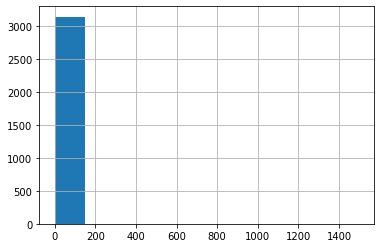

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count